<a href="https://colab.research.google.com/github/maesterpaws/wind_farm/blob/main/Task2v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 2 Advanced Programming**

Luisa Ripoll Alberola and Jonathan Askey

In [ ]:
# Import appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config

import time
import joblib

# Exploratory Data Analysis

In [ ]:
from google.colab import drive

# Jon's directory
# drive.mount('/content/drive/', force_remount = True)
# %cd /content/drive/MyDrive/SecondAssignment_AdvProgramming

# Luisa's directory
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/

Mounted at /content/drive/
/content/drive/MyDrive


In [ ]:
data = pd.read_csv('wind_available.csv.gzip', compression="gzip")
data.head()

,energy,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,402.71,2005,1,2,18,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,...,-4.683596,NaN,-4.407196,NaN,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,696.80,2005,1,3,0,NaN,NaN,2.521184e+06,2.513088e+06,NaN,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,NaN
2,1591.15,2005,1,3,6,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,NaN,...,-1.454105,NaN,-1.138290,NaN,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
3,1338.62,2005,1,3,12,NaN,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
4,562.50,2005,1,3,18,2.529543e+06,NaN,2.513702e+06,2.505782e+06,2.497861e+06,...,1.939031,NaN,NaN,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986


*   t2m: 2 metre temperature
*   u10: 10 metre U wind component
*   v10: 10 metre V wind component
*   u100: 100 metre U wind component
*   v100: 100 metre V wind component
*   cape: Convective available potential energy
*   flsr: Forecast logarithm of surface roughness for heat
*   fsr: Forecast surface roughness
*   iews: Instantaneous eastward turbulent surface stress
*   inss: Instantaneous northward turbulent surface
*   lai_hv: Leaf area index, high vegetation
*   lai_lv: Leaf area index, low vegetation
*   u10n: Neutral wind at 10 m u-component
*   v10n: Neutral wind at 10 m v-component
*   stl1: Soil temperature level 1
*   stl2: Soil temperature level 2
*   stl3: Soil temperature level 3
*   stl4: Soil temperature level 4
*   sp: Surface pressure
*   p54.162: Vertical integral of temperature
*   p59.162: Vertical integral of divergence of kinetic energy
*   p55.162: Vertical integral of water vapour

All these 22 variables are numerical. In fact, our dataset has 22x25=550 columns, as each variable is measured in each of the 25 portions of our study area. We see there are four observations per day, every 6 hours starting at midnight.

We want to study the energy production (which is a numerical variable, in kWh or a similar unit), and be able to predict the energy productions of a given day. Then, we are dealing with a regression problem.


In [ ]:
# study of constant columns
sum(data.nunique() == 1)

0

There are not constant columns.

In [ ]:
# Set Pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Reset display options to default values
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

# Number of NaNs per column
# data.isna().sum()

As there is a considerable amount of NaNs, we will have to correct them. Is it correct to fill the NaNs with the mean? The reality is maybe there is a more correct way to deal with this: as our data is temporal, maybe a better solution is to take the last value. For this purpose, we will study the mean and frequency table of "p54.162.1", for example.

"p54.162.1" has 372 NaN values. Its mean is around 2.51E6. However, if we study its histogram, we see it follows a distribution in which higher and lower values exist in great amount. This also occurs in the observations taken for the same hour.

In [ ]:
# data['p54.162.1'].isna().sum()
data['p54.162.1'].mean()

2512664.2240877515

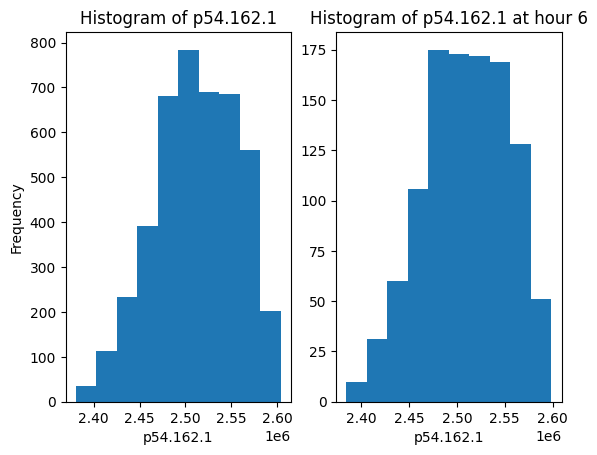

In [ ]:
rows, cols = 1, 2

# histogram of one variable
plt.subplot(rows, cols, 1)
plt.hist(data['p54.162.1'])
plt.xlabel('p54.162.1')
plt.ylabel('Frequency')
plt.title('Histogram of p54.162.1')

# histogram of 'p54.162.1' in hour 6
# Filter data for hour == 6
data_hour6 = data[data['hour'] == 6]

# Extract values for the variable p54.162.1
p54_values = data_hour6['p54.162.1']

plt.subplot(rows, cols, 2)
plt.hist(p54_values)
plt.xlabel('p54.162.1')
plt.title('Histogram of p54.162.1 at hour 6')
plt.show()

As the data of certain observation depends more on the previous observation than on other observations of the same hour in other days, we are going to interpolate the missing values. This is the most suitable option for the characteristics of our data.

In [ ]:
# data[data.columns[4:6]]
data1 = data.interpolate(method='linear', limit_direction='both')
sum(data1.isna().sum() !=0)

0

# Train-test split

Our data is not i.i.d. because of having temporal order, so we won't randomly shuffle it before doing the partition, as we saw in class.

In [ ]:
# Calculate number of values for train and test partitions
n_train = math.ceil(len(data1) * 0.7)
n_test = len(data1) - n_train

# Split data set into train and test partitions
train = data1.head(n_train)
test = data1.tail(n_test)

# Separate predictors from response variable for training set
y_train = train[['energy']].copy()
X_train = train.drop('energy', axis=1)

# Separate predictors from response variable for testing set
y_test = test[['energy']].copy()
X_test = test.drop('energy', axis=1)

As we are dealing with a regression problem, we will use the metric Root Mean Squared Error (RMSE).

# Trees and KNN

Using default hyper-parameters, evaluate Trees and KNN on the testing partition. For KNN, you should use a pipeline with preprocessing included (scaling, at least). You can compare 2 scaling methods for KNN.

In [ ]:
# Run Trees
clf = tree.DecisionTreeRegressor()
ttime_tree_1_start = time.time()
clf.fit(X_train, y_train)
ttime_tree_1_fin = time.time()
ttime_tree_1 = ttime_tree_1_fin - ttime_tree_1_start
print(f"Training time for Tree w/o HPO: {ttime_tree_1:.4f}")

y_test_pred = clf.predict(X_test)

# Create a pipeline for KNN with StandardScaler
pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('scaler', StandardScaler()),
    # ('selector', SelectKBest(score_func=f_regression, k=5)),
    ('knn', KNeighborsRegressor())
])

# Flatten the response variable y
y_flattened = y_train.values.ravel()

# Fit the pipeline with training data
ttime_knn_std_start = time.time()
pipeline.fit(X_train, y_flattened)
ttime_knn_std_fin = time.time()
ttime_knn_std = ttime_knn_std_fin - ttime_knn_std_start
print(f"Training time for KNN StandardScaler(): {ttime_knn_std:.4f}")

# Make predictions on the test set using the pipeline
y_test_pred2 = pipeline.predict(X_test)

# Repeat the process using a different scaler (Normalizer in this case)
pipeline2 = Pipeline([
    ('impute', KNNImputer()),
    ('scaler', Normalizer()),
    # ('selector', SelectKBest(score_func=f_regression, k=5)),
    ('knn', KNeighborsRegressor())
])

ttime_knn_norm_start = time.time()
pipeline2.fit(X_train, y_flattened)
ttime_knn_norm_fin = time.time()
ttime_knn_norm = ttime_knn_norm_fin - ttime_knn_norm_start
print(f"Training time for KNN Normalizer(): {ttime_knn_norm:.4f}")

y_test_pred3 = pipeline2.predict(X_test)
print(pipeline2.get_params())

# Calculate RMSE for Trees
rmse1 = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"RMSE for Trees: {rmse1:.4f}")

# Calculate RMSE for KNN with StandardScaler()
rmse2 = np.sqrt(mean_squared_error(y_test, y_test_pred2))
print(f"RMSE for KNN with StandardScaler: {rmse2:.4f}")

# Calculate RMSE for KNN with Normalizer()
rmse3 = np.sqrt(mean_squared_error(y_test, y_test_pred3))
print(f"RMSE for KNN with Normalizer(): {rmse3:.4f}")

Training time for Tree w/o HPO: 2.5952
Training time for KNN StandardScaler(): 0.0961
Training time for KNN Normalizer(): 0.0820
{'memory': None, 'steps': [('impute', KNNImputer()), ('scaler', Normalizer()), ('knn', KNeighborsRegressor())], 'verbose': False, 'impute': KNNImputer(), 'scaler': Normalizer(), 'knn': KNeighborsRegressor(), 'impute__add_indicator': False, 'impute__copy': True, 'impute__keep_empty_features': False, 'impute__metric': 'nan_euclidean', 'impute__missing_values': nan, 'impute__n_neighbors': 5, 'impute__weights': 'uniform', 'scaler__copy': True, 'scaler__norm': 'l2', 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
RMSE for Trees: 540.7988
RMSE for KNN with StandardScaler: 461.8398
RMSE for KNN with Normalizer(): 653.8005


The best RMSE was obtained using KNN with the standard scaler. We see the difference between using the standard scaler and the normalizer is high. KNN with standard scaler, using all features, has a better performance than trees.

# Hyper-Parameter Optimization (HPO)

Now, do hyper-parameter tuning (HPO) for trees and KNN. Report a summary (use a table) of your results so far and draw some conclusions about accuracy results, comparing the evaluation of all alternatives tested.

We will do the hyper-parameter tuning using pipelines. We will compute grid search, as it is a more thorough analysis, evaluating all possible combinations. In the k-fold imputation, it is selected the option shuffle = False, because we are dealing with temporal data.

In [ ]:
## Trees

# Define pipeline
dt_pipeline = Pipeline([
    ('impute', KNNImputer()),
    ('tree', DecisionTreeRegressor())
])

# Define hyper-parameter space
dt_param_grid = {
    'tree__max_depth': [None, 10, 20, 30],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4]
}

# Define a 5-fold cross-validation grid-search
dt_inner_cv = KFold(n_splits=5, shuffle=False)
dt_grid = GridSearchCV(dt_pipeline,
                       dt_param_grid,
                       scoring='neg_root_mean_squared_error',
                       cv=dt_inner_cv, n_jobs=1, verbose=1)
ttime_tree_hpo_start = time.time()
dt_grid = dt_grid.fit(X_train, y_train.values.ravel())
ttime_tree_hpo_fin = time.time()
ttime_tree_hpo = ttime_tree_hpo_fin - ttime_tree_hpo_start

# Predict on test set
y_test_pred_dt = dt_grid.predict(X_test)

# Calculate RMSE for Trees
rmse_dt = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
print(f"RMSE for Trees: {rmse_dt:.4f}")

# Return best hyper-parameters
print("Best Hyperparameters for Decision Trees:", dt_grid.best_params_)
print("Best Score for Decision Trees:", dt_grid.best_score_)

## KNN

# Define steps in the pipeline
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest(score_func=f_regression)
knn = KNeighborsRegressor()

# Define the pipeline
knn_pipeline = Pipeline([
    ('impute', imputer),
    ('scaler', scaler),
    ('select', selector),
    ('knn_regression', knn)
])

# Define hyper-parameter space
knn_param_grid = {
    # 'select__k': [2, 10, 15],
    'knn_regression__n_neighbors': [1, 3, 5, 7, 15, 21]
}

# Define a 5-fold cross-validation grid-search
knn_inner_cv = KFold(n_splits=5, shuffle=False)
knn_grid = GridSearchCV(knn_pipeline,
                        knn_param_grid,
                        scoring='neg_root_mean_squared_error',
                        cv=knn_inner_cv, n_jobs=1, verbose=1)
ttime_knn_hpo_start = time.time()
knn_grid = knn_grid.fit(X_train, y_train.values.ravel())
ttime_knn_hpo_fin = time.time()
ttime_knn_hpo = ttime_knn_hpo_fin - ttime_knn_hpo_start

# Predict on test set
y_test_pred_knn = knn_grid.predict(X_test)

# Calculate RMSE for KNN
rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
print(f"RMSE for KNN: {rmse_knn:.4f}")

# Return best hyper-parameters
print("Best Hyperparameters for KNN:", knn_grid.best_params_)
print("Best Score for KNN:", knn_grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
RMSE for Trees: 487.5173
Best Hyperparameters for Decision Trees: {'tree__max_depth': 10, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 5}
Best Score for Decision Trees: -448.1939614667334
Fitting 5 folds for each of 6 candidates, totalling 30 fits
RMSE for KNN: 622.0769
Best Hyperparameters for KNN: {'knn_regression__n_neighbors': 21}
Best Score for KNN: -596.1653869738304


In [ ]:
## Trees
# Get all hyperparameters and their evaluation as a dataframe
dt_results_df = pd.DataFrame(dt_grid.cv_results_).loc[:,['params', 'mean_test_score']]
# Now, sort by score. Best hyper-parameters at the top
dt_results_df = dt_results_df.sort_values(by=['mean_test_score'], ascending=False)
# Print the top 10 results
dt_results_df.iloc[:10,]

,params,mean_test_score
16,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-448.193961
17,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-449.401650
15,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-451.531865
14,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-457.148325
12,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-458.710872
11,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-461.701372
26,"{'tree__max_depth': 20, 'tree__min_samples_lea...",-467.229137
13,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-467.377143
10,"{'tree__max_depth': 10, 'tree__min_samples_lea...",-468.643534
8,"{'tree__max_depth': None, 'tree__min_samples_l...",-469.136185


We see in this table that the best hyper parameters for trees are:
- a maximum depth of 10,
- a minimum number of samples a node must contain in order to consider splitting (min_samples_leaf) of 4, and
- a minimum number of samples required to be at a leaf node of 5.

Let's now compare all the RMSEs obtained so far:

In [ ]:
# Create a DataFrame with the RMSE values
rmse_data = {
    'Model': ['Trees (w/o HPO)', 'KNN Standard Scaler (w/o HPO)', 'KNN Normalizer (w/o HPO)',
              'Trees (HPO)', 'KNN (HPO)'],
    'RMSE': [rmse1, rmse2, rmse3, rmse_dt, rmse_knn],
    'Training times': [ttime_tree_1, ttime_knn_std, ttime_knn_norm, ttime_tree_hpo, ttime_knn_hpo]
}

rmse_df = pd.DataFrame(rmse_data)

# Display the DataFrame
print(rmse_df)

                           Model        RMSE  Training times
0                Trees (w/o HPO)  540.798849        2.595234
1  KNN Standard Scaler (w/o HPO)  461.839763        0.096082
2       KNN Normalizer (w/o HPO)  653.800497        0.081975
3                    Trees (HPO)  487.517258      335.719616
4                      KNN (HPO)  622.076867        4.481371


We see that we get better solutions in the KNN without hyperparameter tuning, and in trees with hyperparameter tuning. This is strange, as HPO should improve RMSE. This is maybe because the most optimal parameters were not included in the possible selection.

For this reason, we are taking the KNN without HPO as our best model, and we will improve it at the last part of the assignment. Moreover, the tree training time is really long, so it is not computationally optimal and we will prefer other faster models.  

Determining the overall accuracy of a regressor model is a bit more complicated than that of a classification model since it depends on the scale of the data. However, with MSE, we are able to compare our models and determine the best one.

# Feature Selection

In [ ]:
# Define steps in the pipeline
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest()
knn = KNeighborsRegressor()

# Define the pipeline
knn_pipeline = Pipeline([
    ('impute', imputer),
    ('scaler', scaler),
    ('select', selector),
    ('knn_regression', knn)
])

# Set parameter of ideal number of nearest neighbors form HPO
knn_pipeline = knn_pipeline.set_params(**{'knn_regression__n_neighbors':21})

# Define hyper-parameter space for number of features selected
knn_param_grid = {
    'select__k': [50, 75, 90, 100, 120, 130, 140, 150, 160, 170, 200],
    'select__score_func': [f_classif, mutual_info_classif]
}

# Define a 5-fold cross-validation grid-search
knn_inner_cv = KFold(n_splits=5, shuffle=False)
knn_grid = GridSearchCV(knn_pipeline,
                        knn_param_grid,
                        scoring='neg_root_mean_squared_error',
                        cv=knn_inner_cv, n_jobs=1, verbose=1)
knn_grid = knn_grid.fit(X_train, y_train.values.ravel())

# Predict on test set
y_test_pred_knn = knn_grid.predict(X_test)

# Calculate RMSE for KNN
rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
print(f"RMSE for KNN: {rmse_knn:.4f}")

# Return best hyper-parameters
print("Best Hyperparameters for KNN:", knn_grid.best_params_)
print("Best Score for KNN:", knn_grid.best_score_)

# Get best features for prediction
feature_names_after_impute = X_train.columns
selected_feature_names = (knn_grid.best_estimator_.named_steps['select'].
                         get_feature_names_out(input_features = feature_names_after_impute))
feature_scores = knn_grid.best_estimator_.named_steps['select'].scores_
print('Selected features and scores')
for elem in zip(selected_feature_names, feature_scores):
  print(elem)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/usr/local/lib/python3.10/dist-pa

RMSE for KNN: 422.0023
Best Hyperparameters for KNN: {'select__k': 160, 'select__score_func': <function f_classif at 0x7cde04a3f0a0>}
Best Score for KNN: -381.0916475131835
Selected features and scores
('p59.162.1', 0.9887633838904919)
('p59.162.2', 1.1034936132925204)
('p59.162.3', 1.2767850895860424)
('p59.162.4', 1.3811509100313988)
('p59.162.5', 1.2806910257401058)
('p59.162.6', 1.2799351449125511)
('p59.162.7', 1.2692418923429631)
('p59.162.8', 1.267823587268931)
('p59.162.9', 1.2571477002994924)
('p59.162.10', 1.2797220879896487)
('p59.162.11', 1.2560860822238717)
('p59.162.12', 1.2733682628386411)
('p59.162.13', 1.264885522780435)
('p59.162.14', 1.2485825281987726)
('p59.162.15', 1.2820699317449753)
('p59.162.16', 1.2483628077851214)
('p59.162.17', 1.2620386920883233)
('p59.162.18', 1.2468762021061999)
('p59.162.19', 1.2508145582148578)
('p59.162.20', 1.2650332290210498)
('p59.162.21', 1.2583672372932873)
('p59.162.22', 1.2467479822997194)
('p59.162.23', 1.254602332632785)
('p59

Out of the 550 intitial attributes, we find that about 160 attributes are needed for the best model for predicting energy produced. That is approximately one third of the total attributes in the data set.

When looking at the selected features, we find that each wind turbine for most features is significant for making predictions about energy produced. That is, no wind turbine is more useful for making predictions than others.

The most signficant attributes are:
1.   p59.162: Vertical integral of divergence of kinetic energy
2.   u10n: Neutral wind at 10 m u-component
3.   u10: 10 metre U wind component
4.   iews: Instantaneous eastward turbulent surface stress
5.   inss: Instantaneous northward turbulent surface
6.   u100: 100 metre U wind component
7.   v100: 100 metre V wind component

That is 7 out of 22 features provided are significant. These features are related to wind. Naturally, we conclude that data related to wind is best used to predict energy production.

Compared to the KNN without feature selection, feature selection improves our model with a smaller RMSE value.

# Something original

Now, we will use cross-validation in outer-evaluation instead of partitioning our available data in train-test. This way, maybe we can improve RMSE, because we will have more training data available. However, as our data has temporal order, we have to use:
*   Time Series Split Cross-Validation
*   Blocked Cross-Validation (computationally more expensive but avoids data leakage)

In the following code we will try to use time series split cross-validation:

In [ ]:
# data split
y_cv = data1[data1.columns[0]].copy()
X_cv = data1[data1.columns[1:]].copy()

# Select the same features as in feature selection
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features):
        self.selected_features = selected_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.loc[:, self.selected_features]

# As we get the error "UserWarning: Features [0] are constant.", we try to solve it
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_cv)
constant_columns = [column for column in X_cv.columns
                    if column not in
                    X_cv.columns[constant_filter.get_support()]]
X_cv = constant_filter.transform(X_cv)
for column in constant_columns:
    print("Removed ", column)

# Define steps in the pipeline
imputer = KNNImputer()
scaler = StandardScaler()
knn = KNeighborsRegressor()
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed
# selector = FeatureSelector(selected_feature_names)
selector = SelectKBest()

# Define the pipeline
knn_pipeline_final_cv = Pipeline([
    ('impute', imputer),
    ('scaler', scaler),
    ('select', selector),
    ('knn_regression', knn)
])

# Define RMSE as the scoring metric
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Perform cross-validation with TimeSeriesSplit
start_time_knn_cv = time.time()
scores_knn_cv = cross_val_score(knn_pipeline_final_cv, X_cv, y_cv, cv=tscv, scoring=scorer)
end_time_knn_cv = time.time()
execution_time_knn_cv = end_time_knn_cv - start_time_knn_cv

print("RMSE scores:", -scores_knn_cv)
print("Average RMSE:", np.mean(-scores_knn_cv))
print("Execution time for cross-validation:", execution_time_knn_cv)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


RMSE scores: [452.69213442 414.33267584 409.6274252  467.48610006 520.89480521]
Average RMSE: 453.00662814539265
Execution time for cross-validation: 1.2076830863952637


The average RMSE obtained is slightly higher than the one we got before. This may be because I did not select features (the code gives me errors when I try to) or because of data leakage.

# Final Model

In [ ]:
# Predict on test set
y_test_pred_knn = knn_grid.predict(X_test)

# Calculate RMSE for KNN
rmse_knn = np.sqrt(mean_squared_error(y_test, y_test_pred_knn))
print(f"RMSE for KNN: {rmse_knn:.4f}")

RMSE for KNN: 422.0023


The KNN with HPO for k-nearest neighbors AND feature selection gives the lower RMSE value of about 422. This is better than KNN without HPO, which was strangely better than KNN with HPO for k-nearest neighbors only.

In [ ]:
# Separate predictors from response variable for training set
y = data1[['energy']].copy()
X = data1.drop('energy', axis=1)

# Create the final model

# Define steps in the pipeline
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest()
knn = KNeighborsRegressor()

# Define the pipeline
knn_pipeline_final = Pipeline([
    ('impute', imputer),
    ('scaler', scaler),
    ('select', selector),
    ('knn_regression', knn)
])

# Set parameter based on HPO
knn_pipeline_final = knn_pipeline_final.set_params(**{'knn_regression__n_neighbors':21})
knn_pipeline_final = knn_pipeline_final.set_params(**{'select__k': 160})
knn_pipeline_final = knn_pipeline_final.set_params(**{'select__score_func': f_classif})

# Fit model with all the data
knn_pipeline_final = knn_pipeline_final.fit(X, y.values.ravel())

We have the fitted final model. Let's make predictions on the competition data set.

In [ ]:
data_competition = pd.read_csv('wind_competition.csv.gzip', compression="gzip")

# Make predictions on competition data
y_pred_final = knn_pipeline_final.predict(data_competition)

In [ ]:
# Save the final model to a file using joblib
joblib.dump(knn_pipeline_final, 'final_model.joblib')

# Save the predictions to a text file
np.savetxt('predictions.txt', y_pred_final)

# References


*   Godalle, E. (2023) How to deal with missing values in a timeseries in Python?, ProjectPro. Available at: https://www.projectpro.io/recipes/deal-with-missing-values-in-timeseries-in-python (Accessed: 31 December 2023).
*   Shrivastava, S. (2020) Cross validation in Time Series, Medium. Available at: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4 (Accessed: 31 December 2023).
* Chat GPT (see Chat GPT usage report)

